## Columbia University
### ECBM E4040 Neural Networks and Deep Learning. Fall 2022.

## **Task 2: RNN application -- Tweet Sentiment Analysis** (50%)

In this task, you are going to classify the sentiment in tweets into positive and negative using an LSTM model. The code to load the data and see its characteristics has been provided to you. 

In the first task, you will encode the data using one hot encoding and train an LSTM network to classify the sentiment. In the second task, you will replace the one hot encoding with an embedding layer and train another LSTM model. You will then extract the trained embeddings and visualize the word embeddings in 2 dimensions by using TSNE for dimensionality reduction. 

In [1]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import json
import time
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

%load_ext autoreload
%autoreload 2

## Load Data


In [2]:
with open("./tweets_data/vocabulary.pkl", "rb") as f:
    vocabulary = pickle.load(f)

# load our data and separate it into tweets and labels
train_data = json.load(open('tweets_data/trainTweets_preprocessed.json', 'r'))
train_data = list(map(lambda row:(np.array(row[0],dtype=np.int32),str(row[1])),train_data))
train_tweets = np.array([t[0] for t in train_data])
train_labels = np.array([int(t[1]) for t in train_data])

test_data = json.load(open('tweets_data/testTweets_preprocessed.json', 'r'))
test_data = list(map(lambda row:(np.array(row[0],dtype=np.int32),str(row[1])),test_data))
test_tweets = np.array([t[0] for t in test_data])
test_labels = np.array([int(t[1]) for t in test_data])

print("size of original train set: {}".format(len(train_tweets)))
print("size of original test set: {}".format(len(test_tweets)))

# only select first 1000 test sample for test
test_tweets = test_tweets[:1000]
test_labels = test_labels[:1000]

print("*"*100)
print("size of train set: {}, #positive: {}, #negative: {}".format(len(train_tweets), np.sum(train_labels), len(train_tweets)-np.sum(train_labels)))
print("size of test set: {}, #positive: {}, #negative: {}".format(len(test_tweets), np.sum(test_labels), len(test_tweets)-np.sum(test_labels)))

# show text of the idx-th train tweet
# The 'padtoken' is used to ensure each tweet has the same length
idx = 100
train_text = [vocabulary[x] for x in train_tweets[idx]]
print(train_text)
sentiment_label = ["negative", "positive"]
print("sentiment: {}".format(sentiment_label[train_labels[idx]]))

size of original train set: 60000
size of original test set: 20000
****************************************************************************************************
size of train set: 60000, #positive: 30055, #negative: 29945
size of test set: 1000, #positive: 510, #negative: 490
['it', 'will', 'help', 'relieve', 'your', 'stress', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken']
sentiment: positive


In [5]:
len(train_tweets)

60000

## Part 1 LSTM Encoder (15%)

<font color="red"><strong>TODO:</strong></font> Create a single-layer LSTM network to classify tweets.
- Use one hot encoding to represent each word in the tweet.
- Set LSTM units to 128.
- Use Adam optimizer and set batch size to 32.

With these settings, what accuracy could you get? You can try to change some stuff in the network to see if you could get a better accuracy. 

<font color="red"><strong>Hint:</strong></font> tf.one_hot and Keras functional API may be useful.
<br>https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

In [9]:
###################################################
# TODO: Create a single-layer LSTM network.       #
#                                                 #
###################################################
from utils.rnn_utils import one_hot
batch_size = 32

vocab_len = len(vocabulary)
embed_dim = 128
lstm_out = 100


inputs = tf.keras.Input((20,))
x = tf.keras.layers.Lambda(lambda i: one_hot(i, vocab_len))(inputs)
x = tf.keras.layers.LSTM(embed_dim, dropout=0.1, recurrent_dropout=0.1)(tf.cast(x, tf.float32))
# x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)
model.summary()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              metrics=['accuracy'])
history_LSTM = model.fit(train_tweets, train_labels, batch_size=batch_size, epochs=15, validation_data=(test_tweets, test_labels),)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 20, 7597)          0         
_________________________________________________________________
tf.cast_2 (TFOpLambda)       (None, 20, 7597)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               3955712   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 3,955,841
Trainable params: 3,955,841
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1875/1875 [==============================] - 16s 8ms/step - loss: 0.5850 - accuracy: 0.6798 - val_loss: 

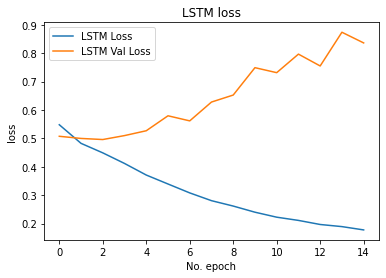

In [10]:
plt.plot(history_LSTM.history['loss'], label='LSTM Loss')
plt.plot(history_LSTM.history['val_loss'], label='LSTM Val Loss')
plt.title('LSTM loss')
plt.ylabel('loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

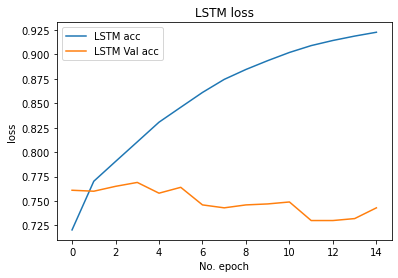

In [11]:
plt.plot(history_LSTM.history['accuracy'], label='LSTM acc')
plt.plot(history_LSTM.history['val_accuracy'], label='LSTM Val acc')
plt.title('LSTM loss')
plt.ylabel('loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

## Part 2: Embedding Lookup layer (20%)

### Define an embedding layer

It's not hard to imagine that in the previous practices, the input we fed in are very sparse because each word was represented as a one-hot vector. This makes it difficult for the network to understand what story the input data is telling. A useful technique is *Word Embedding*.

*Word Embedding*: instead of using a one-hot vector to represent each word, we can add a word embedding matrix in which each word is represented as a low-dimensional vector. Note that this representation is not sparse any more, because we're working in a continuous vector space now. Words that share similar/related semantic meaning should be 'close to each other' in this vector space (we could define a distance measure to estimate the closeness).

<font color="red"><strong>TODO:</strong></font> Define a similar model as above with some improvements.
- Use an Embedding layer instead of one hot embedding.
- Write a custom training loop to train the model instead of using model.fit().
- Write a custom loop gives you complete control over how the model is trained.
- Report loss and accuracy for training and validation after each epoch.
- Display the loss value after every 500 steps. 

Do you see any difference in accuracy? What about training time? What inference can you draw?

**Hints**: Refer to the link below.
<br>https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch


In [12]:
###################################################
# TODO: Create a single-layer LSTM network        #
#       using Embedding layer                     #
###################################################
batch_size = 32
vocab_len = len(vocabulary)
embed_dim = 128
lstm_out = 100

inputs = tf.keras.Input((20,))
embed = tf.keras.layers.Embedding(vocab_len, embed_dim, input_length=train_tweets.shape[1])(inputs)
x = tf.keras.layers.SpatialDropout1D(0.4)(embed)
x = tf.keras.layers.LSTM(128)(x)
# x = tf.keras.layers.Dense(64,activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)
model.summary()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              metrics=['accuracy'])
history_Embedded = model.fit(train_tweets, train_labels, batch_size=batch_size, epochs=15, validation_data=(test_tweets, test_labels),)

###################################################
# END TODO                                        #
###################################################

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 20, 128)           972416    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 20, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 1,104,129
Trainable params: 1,104,129
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1875/1875 [==============================] - 21s 11ms/step - loss: 0.5750 - accuracy: 0.6938 - val_loss:

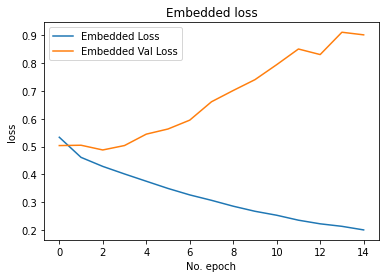

In [13]:
plt.plot(history_Embedded.history['loss'], label='Embedded Loss')
plt.plot(history_Embedded.history['val_loss'], label='Embedded Val Loss')
plt.title('Embedded loss')
plt.ylabel('loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

## Part 3: Visualize word vectors via tSNE (15%)

<font color="red"><strong>TODO:</strong></font>
- First, you need to retrieve embedding matrix from the network.
- Then use tSNE to reduce each low-dimensional word vector into a 2D vector.
- And then, you should visualize some interesting word pairs in 2D panel. (You may find scatter function in matplotlib.pyplot useful.)

<font color="red"><strong>Hint:</strong></font> You can use TSNE tool provided in scikit-learn. And if you encounter dead kernel problem caused by "Intel MKL FATAL ERROR: Cannot load libmkl_avx.so or libmkl_def.so", please reinstall scikit-learn without MKL, ie., conda install nomkl numpy scipy scikit-learn numexpr.

Here we provide some word pairs for you, like female-male or country-capital. And you can observe that these word-pair will look parallel with each other in a 2D tSNE panel. And you can find some other words and explore their relationship.


In [ ]:
# word pairs provided
female_male = ["men", "women", "king", "queen"]
country_capital = ["spain", "madrid", "italy", "rome", "japan", "tokyo"]
#you may try some other words as well

###################################################
# TODO: Visualize word vectors using TSNE.        #
#                                                 #
###################################################


###################################################
# END TODO                                        #
###################################################

<font color="red"><strong>Note:</strong></font> Install **sklearn** if you haven't already. 

```
> pip install sklearn
```

In [1]:
##Solution

from sklearn.manifold import TSNE
embeddings = model.layers[0].get_weights()[0]
emb_tsne = TSNE(n_components=2).fit_transform(embeddings)

NameError: name 'model' is not defined

In [ ]:
##Solution

vocab_list = list(vocabulary)
sample_words = female_male #["master", "teacher", "student", "graduate", "learning", "teach", "college", "campus"]
indices =[]
for word in sample_words:
  indices.append(vocab_list.index(word))

points = emb_tsne[indices]
plt.scatter(points[:, 0], points[:, 1], 20)

for text, pts in zip(sample_words, points):
    # plt.annotate(text, (X_tsne[idx,0],X_tsne[idx,1]), fontsize=20)
    plt.annotate(text, (int(pts[0]), int(pts[1])))
    